In [1]:
import logging
import os

import numpy as np
import pandas as pd
# import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import thread_map
from sklearn.model_selection import train_test_split
from torchinfo import summary
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score

from functions import *

torch.backends.cudnn.benchmark = True
print(torch.backends.cudnn.version())
print(torch.version.cuda)

8801
12.1


In [2]:
plt.rcParams.update({"font.size": 12})


In [3]:
FPS_MASK = [ 1,    4,   13,   15,   33,   36,   64,   80,  114,  119,  128,
         147,  175,  225,  250,  283,  293,  294,  301,  314,  322,  356,
         361,  362,  378,  389,  420,  512,  540,  561,  579,  591,  636,
         642,  650,  656,  659,  694,  695,  698,  710,  725,  726,  730,
         739,  784,  794,  807,  831,  841,  849,  875,  881,  887,  893,
         904,  923,  926,  935,  946, 1017, 1019]

In [4]:
MACCS_MASK = [ 42,  57,  62,  65,  66,  72,  74,  75,  77,  78,  79,  80,  81,
         83,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
        123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
        149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
        162, 163, 164, 165]

In [5]:
def calc_metrics(preds, targets):
    accuracy = 1 - np.sum(np.abs(preds - targets), axis=0) / len(targets)
    precision = np.sum(preds * targets, axis=0) / (np.sum(preds, axis=0)+ 1e-8)
    recall = np.sum(preds * targets, axis=0) / (np.sum(targets, axis=0)+ 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return np.stack([accuracy, precision, recall, f1],axis=-1)

## NIST 42 TEST

### FPS

In [6]:
# fps_calc = np.loadtxt("../Data/Out/TST_fps_calc.txt")
fps_calc = np.loadtxt("../Data/Out/TST_42_fps.txt")
deep_fp_preds = (np.loadtxt("../Data/Out/TST_DEEPEI_fp_preds.txt") > 0.5).astype(float)
fc_fp_preds = (np.loadtxt("../Data/Out/TST_FC_fps_preds.txt") > 0.5).astype(float)
fclite_fp_preds = (np.loadtxt("../Data/Out/TST_FCLite_fps_preds.txt") > 0.5).astype(float)
fclite_42_fp_preds = (np.loadtxt("../Data/Out/TST_FCLite_42_fps_preds.txt") > 0.5).astype(
    float
)


Old plot

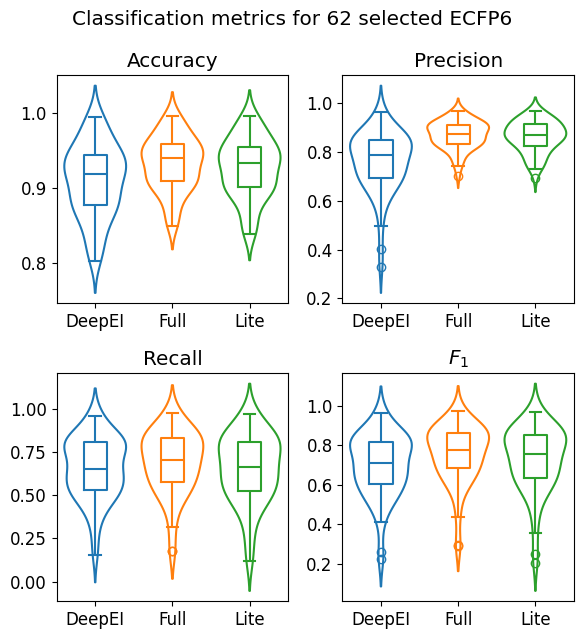

In [7]:
# fps_calc = np.loadtxt("../Data/Out/TST_fps_calc.txt")
fps_calc = np.loadtxt("../Data/Out/TST_42_fps.txt")

deep_fp_preds = (np.loadtxt("../Data/Out/TST_DEEPEI_fp_preds.txt") > 0.5).astype(float)
fc_fp_preds = (np.loadtxt("../Data/Out/TST_FC_fps_preds.txt") > 0.5).astype(float)
fclite_fp_preds = (np.loadtxt("../Data/Out/TST_FCLite_fps_preds.txt") > 0.5).astype(float)
fclite_42_fp_preds = (np.loadtxt("../Data/Out/TST_FCLite_42_fps_preds.txt") > 0.5).astype(
    float
)


plot_df = pd.DataFrame()
plot_df[["DeepEI_Acc", "DeepEI_Pre", "DeepEI_Rec", "DeepEI_F1"]] = calc_metrics(
    deep_fp_preds, fps_calc
)
plot_df[["Full_Acc", "Full_Pre", "Full_Rec", "Full_F1"]] = calc_metrics(
    fc_fp_preds, fps_calc
)
plot_df[["Lite_Acc", "Lite_Pre", "Lite_Rec", "Lite_F1"]] = calc_metrics(
    fclite_42_fp_preds, fps_calc
)

fig, axs = plt.subplots(2, 2, figsize=(6, 6.5))
fig.suptitle(f"Classification metrics for 62 selected ECFP6")
titles = ["Accuracy", "Precision", "Recall", r"$F_1$"]
for i, val in enumerate(["Acc", "Pre", "Rec", "F1"]):
    sns.boxplot(
        plot_df[[x for x in plot_df.columns if val in str(x)]],
        ax=axs[i // 2][i % 2],
        width=0.3,
        fill=False,
    )
    sns.violinplot(
        plot_df[[x for x in plot_df.columns if val in str(x)]],
        ax=axs[i // 2][i % 2],
        inner=None,
        fill=None,
    )
    axs[i // 2][i % 2].set_title(titles[i])
    axs[i // 2][i % 2].set_xticks(
        ticks=[x for x in plot_df.columns if val in str(x)],
        labels=[x.split("_")[0] for x in plot_df.columns if val in str(x)],
    )
fig.tight_layout()
fig.savefig("../Data/Out/Fig_S1.jpg",dpi=1000)

### MACCS

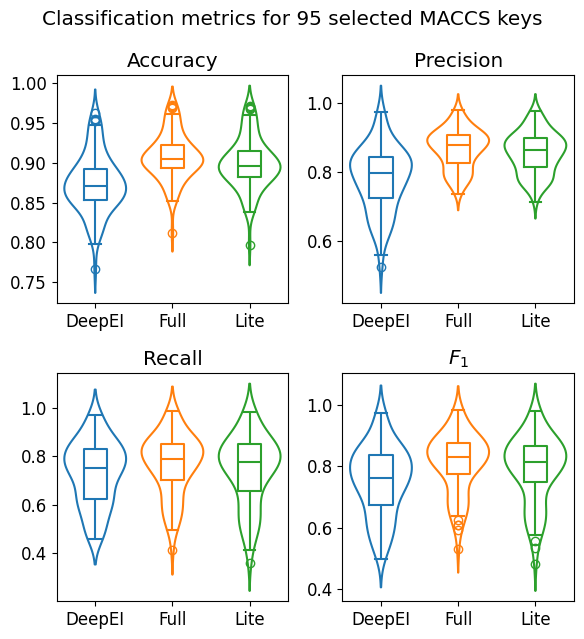

In [8]:
maccs_calc = (np.loadtxt("../Data/Out/TST_maccs_calc.txt") > 0.5).astype(float)
deep_maccs_preds = (np.loadtxt("../Data/Out/TST_DEEPEI_maccs_preds.txt") > 0.5).astype(float)
fc_maccs_preds = (np.loadtxt("../Data/Out/TST_FC_maccs_preds.txt") > 0.5).astype(float)
fclite_maccs_preds = (np.loadtxt("../Data/Out/TST_FCLite_maccs_preds.txt") > 0.5).astype(
    float
)
fclite_42_maccs_preds = (
    np.loadtxt("../Data/Out/TST_FCLite_42_maccs_preds.txt") > 0.5
).astype(float)


plot_df = pd.DataFrame()
plot_df[["DeepEI_Acc", "DeepEI_Pre", "DeepEI_Rec", "DeepEI_F1"]] = calc_metrics(
    deep_maccs_preds, maccs_calc
)
plot_df[["Full_Acc", "Full_Pre", "Full_Rec", "Full_F1"]] = calc_metrics(
    fc_maccs_preds, maccs_calc
)
plot_df[["Lite_Acc", "Lite_Pre", "Lite_Rec", "Lite_F1"]] = calc_metrics(
    fclite_42_maccs_preds, maccs_calc
)

fig, axs = plt.subplots(2, 2, figsize=(6, 6.5))
fig.suptitle(f"Classification metrics for 95 selected MACCS keys")
titles = ["Accuracy", "Precision", "Recall", r"$F_1$"]
for i, val in enumerate(["Acc", "Pre", "Rec", "F1"]):
    sns.boxplot(
        plot_df[[x for x in plot_df.columns if val in str(x)]],
        ax=axs[i // 2][i % 2],
        width=0.3,
        fill=False,
    )
    sns.violinplot(
        plot_df[[x for x in plot_df.columns if val in str(x)]],
        ax=axs[i // 2][i % 2],
        inner=None,
        fill=None,
    )
    axs[i // 2][i % 2].set_title(titles[i])
    axs[i // 2][i % 2].set_xticks(
        ticks=[x for x in plot_df.columns if val in str(x)],
        labels=[x.split("_")[0] for x in plot_df.columns if val in str(x)],
    )
fig.tight_layout()
fig.savefig("../Data/Out/Fig_S2.jpg",dpi=1000)


### Together

In [9]:
deep_preds = np.hstack([deep_fp_preds,deep_maccs_preds])
fc_preds = np.hstack([fc_fp_preds,fc_maccs_preds])
fclite_preds = np.hstack([fclite_fp_preds,fclite_maccs_preds])
calcs = np.hstack([fps_calc,maccs_calc])

In [10]:
metrics = ["Accuracy", "Precision", "Recall", "F1"]

In [11]:
mean_df = pd.DataFrame()
mean_df[["DeepEI", "Full", "Lite"]] = [
    dict(zip(metrics, calc_metrics(x, calcs).mean(axis=0)))
    for x in [deep_preds, fc_preds, fclite_preds]
]
mean_df.round(2)

,DeepEI,Full,Lite
Accuracy,0.89,0.92,0.91
Precision,0.77,0.87,0.86
Recall,0.70,0.73,0.71
F1,0.73,0.79,0.77


In [12]:
median_df = pd.DataFrame()
median_df[["DeepEI", "Full", "Lite"]] = [
    dict(zip(metrics, np.median(calc_metrics(x, calcs),axis=0)))
    for x in [deep_preds, fc_preds, fclite_preds]
]
median_df.round(2)

,DeepEI,Full,Lite
Accuracy,0.88,0.91,0.91
Precision,0.79,0.88,0.87
Recall,0.73,0.77,0.75
F1,0.75,0.82,0.80


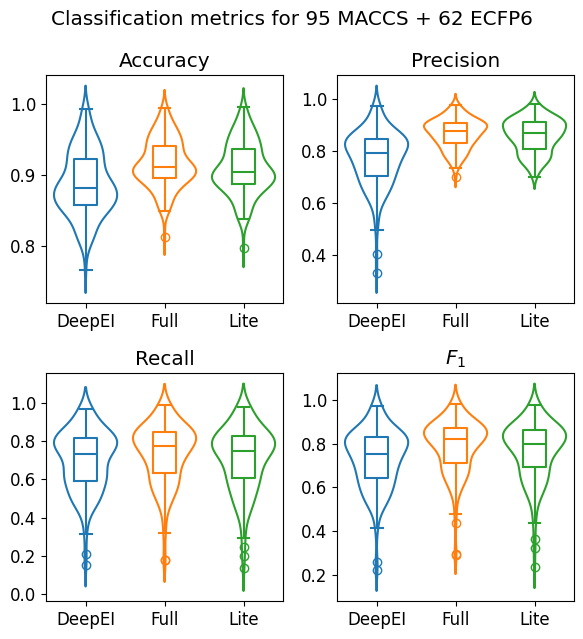

In [13]:
deep_preds = np.hstack([deep_fp_preds,deep_maccs_preds])
fc_preds = np.hstack([fc_fp_preds,fc_maccs_preds])
fclite_preds = np.hstack([fclite_fp_preds,fclite_maccs_preds])
calcs = np.hstack([fps_calc,maccs_calc])

mix_plot_df = pd.DataFrame()
mix_plot_df[["DeepEI_Acc", "DeepEI_Pre", "DeepEI_Rec", "DeepEI_F1"]] = calc_metrics(
    deep_preds, calcs
)
mix_plot_df[["Full_Acc", "Full_Pre", "Full_Rec", "Full_F1"]] = calc_metrics(
    fc_preds, calcs
)
mix_plot_df[["Lite_Acc", "Lite_Pre", "Lite_Rec", "Lite_F1"]] = calc_metrics(
    fclite_preds, calcs
)

fig, axs = plt.subplots(2, 2, figsize=(6, 6.5))
fig.suptitle(f"Classification metrics for 95 MACCS + 62 ECFP6")
titles = ["Accuracy", "Precision", "Recall", r"$F_1$"]
for i, val in enumerate(["Acc", "Pre", "Rec", "F1"]):
    sns.boxplot(
        mix_plot_df[[x for x in mix_plot_df.columns if val in str(x)]],
        ax=axs[i // 2][i % 2],
        width=0.3,
        fill=False,
    )
    sns.violinplot(
        mix_plot_df[[x for x in mix_plot_df.columns if val in str(x)]],
        ax=axs[i // 2][i % 2],
        inner=None,
        fill=None,
    )
    axs[i // 2][i % 2].set_title(titles[i])
    axs[i // 2][i % 2].set_xticks(
        ticks=[x for x in mix_plot_df.columns if val in str(x)],
        labels=[x.split("_")[0] for x in mix_plot_df.columns if val in str(x)],
    )
fig.tight_layout()
fig.savefig("../Data/Out/Fig_1.jpg",dpi=1000)

## Seeded Runs

In [14]:
seed_df = pd.DataFrame()
for a in range(42,48):
    fps_calc = np.loadtxt(f"../Data/Out/TST_{a}_fps.txt")
    maccs_calc = np.loadtxt(f"../Data/Out/TST_{a}_maccs.txt")
    calcs = np.hstack([fps_calc,maccs_calc])
    fclite_fp_preds = (np.loadtxt(f"../Data/Out/TST_FCLite_{a}_fps_final.txt")>0.5).astype(float)
    fclite_maccs_preds = (np.loadtxt(f"../Data/Out/TST_FCLite_{a}_maccs_final.txt")>0.5).astype(float)
    preds = np.hstack([fclite_fp_preds,fclite_maccs_preds])
    seed_df[[f"Lite.{a}_Acc", f"Lite.{a}_Pre", f"Lite.{a}_Rec", f"Lite.{a}_F1"]] = calc_metrics(preds, calcs)
seed_df

,Lite.42_Acc,Lite.42_Pre,Lite.42_Rec,Lite.42_F1,Lite.43_Acc,Lite.43_Pre,Lite.43_Rec,Lite.43_F1,Lite.44_Acc,Lite.44_Pre,...,Lite.45_Rec,Lite.45_F1,Lite.46_Acc,Lite.46_Pre,Lite.46_Rec,Lite.46_F1,Lite.47_Acc,Lite.47_Pre,Lite.47_Rec,Lite.47_F1
0,0.861735,0.847555,0.576552,0.686268,0.865022,0.845390,0.597537,0.700176,0.860942,0.826593,...,0.597522,0.700143,0.865287,0.855985,0.581197,0.692321,0.862075,0.836349,0.597953,0.697339
1,0.934721,0.793366,0.519772,0.628067,0.937857,0.822807,0.511822,0.631083,0.936081,0.829519,...,0.522279,0.632324,0.936421,0.818449,0.503433,0.623406,0.938914,0.833141,0.520751,0.640906
2,0.952779,0.921929,0.801831,0.857696,0.952665,0.922967,0.806250,0.860669,0.954441,0.931666,...,0.792328,0.859700,0.953459,0.927121,0.807156,0.862989,0.952930,0.936607,0.790108,0.857143
3,0.908617,0.691830,0.239785,0.356135,0.910279,0.736728,0.241821,0.364123,0.910090,0.732684,...,0.253580,0.375388,0.906955,0.725326,0.264337,0.387466,0.909637,0.746781,0.244039,0.367865
4,0.900042,0.934589,0.937130,0.935858,0.900382,0.929629,0.943639,0.936582,0.897813,0.926588,...,0.941690,0.936200,0.898039,0.939609,0.929204,0.934377,0.900344,0.931703,0.941939,0.936793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,0.954781,0.953743,0.965475,0.959573,0.955498,0.958367,0.961627,0.959995,0.953950,0.957696,...,0.960596,0.960302,0.953987,0.958657,0.958396,0.958526,0.955385,0.955965,0.963374,0.959656
153,0.966945,0.973463,0.978256,0.975853,0.969816,0.979374,0.975809,0.977588,0.967323,0.977180,...,0.975844,0.976357,0.968456,0.979279,0.974096,0.976681,0.967058,0.977428,0.973828,0.975625
154,0.944354,0.958186,0.968077,0.963106,0.945525,0.960241,0.966507,0.963364,0.946621,0.965870,...,0.969483,0.966354,0.946356,0.961624,0.966687,0.964149,0.944996,0.965110,0.961210,0.963156
155,0.936232,0.952930,0.974471,0.963580,0.935892,0.957850,0.969099,0.963442,0.931774,0.954415,...,0.968178,0.962696,0.931434,0.952668,0.969203,0.960864,0.931434,0.956794,0.964579,0.960671


In [15]:
seed_stats = pd.DataFrame()
for i, val in enumerate(["Acc", "Pre", "Rec", "F1"]):
    # print(val)
    # print(seed_df[[x for x in seed_df.columns if val in str(x)]].median(axis=0).describe())
    seed_stats[val] = seed_df[[x for x in seed_df.columns if val in str(x)]].median(axis=0).describe()
seed_stats.round(4).T[["mean","std"]]

,mean,std
Acc,0.9044,0.0006
Pre,0.8705,0.0037
Rec,0.7513,0.0047
F1,0.8001,0.0042


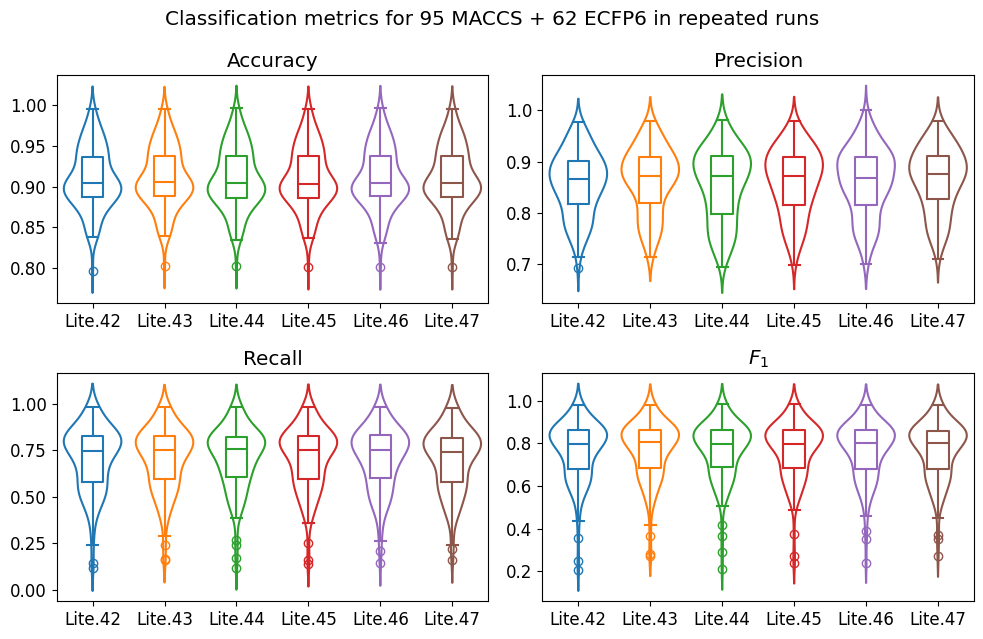

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6.5))
fig.suptitle(f"Classification metrics for 95 MACCS + 62 ECFP6 in repeated runs")
titles = ["Accuracy", "Precision", "Recall", r"$F_1$"]
for i, val in enumerate(["Acc", "Pre", "Rec", "F1"]):
    sns.boxplot(
        seed_df[[x for x in seed_df.columns if val in str(x)]],
        ax=axs[i // 2][i % 2],
        width=0.3,
        fill=False,
    )
    sns.violinplot(
        seed_df[[x for x in seed_df.columns if val in str(x)]],
        ax=axs[i // 2][i % 2],
        inner=None,
        fill=None,
    )
    axs[i // 2][i % 2].set_title(titles[i])
    axs[i // 2][i % 2].set_xticks(
        ticks=[x for x in seed_df.columns if val in str(x)],
        labels=[x.split("_")[0] for x in seed_df.columns if val in str(x)],
    )
fig.tight_layout()
fig.savefig("../Data/Out/Fig_S3.jpg",dpi=1000)